In [1]:
%cd /Users/gduval/Documents/TOSICA

import TOSICA
import scanpy as sc
import numpy as np
import warnings 
import pandas as pd
import anndata as ad
warnings.filterwarnings ("ignore")

/Users/gduval/Documents/TOSICA


Information of GPU

In [2]:
import torch
from sklearn.model_selection import train_test_split
print(torch.__version__)
#print(torch.cuda.get_device_capability(device=None),  torch.cuda.get_device_name(device=None))

2.4.0


Reference data

In [3]:
ref_adata = sc.read('../data/ref_sbm/mATLAS_Marrow_facs.h5ad')
ref_adata = ref_adata[:,ref_adata.var_names]
#print(ref_adata)
#print(ref_adata.obs['free_annotation'].value_counts())

train_data = sc.read('data/demo_train.h5ad')
test_data = sc.read('data/demo_test.h5ad')
print(train_data)
print(test_data)

AnnData object with n_obs × n_vars = 10600 × 3000
    obs: 'Celltype'
    var: 'Gene Symbol'
AnnData object with n_obs × n_vars = 4218 × 3000
    obs: 'Celltype'
    var: 'Gene Symbol'


Alternative data loading method

In [ ]:
# Load the reference and query datasets
all_data = sc.read("../input/matlas-facs/mATLAS_Marrow_facs.h5ad")

# Select most variable genes maybe ?
sc.pp.highly_variable_genes(all_data, n_top_genes=8000)
all_data = all_data[:, all_data.var["highly_variable"]]

# Keep only a small subset of the data
#fraction = 0.4
#sampled_idx = np.random.choice(all_data.n_obs, 
                               #int(all_data.n_obs * fraction), 
                               #replace=False)
#print(len(sampled_idx))
#subset_data = all_data[sampled_idx, :].copy() 

# Split into train and test
train_idx, test_idx = train_test_split(
np.arange(all_data.n_obs), test_size=0.2, random_state=42
) 
adata = all_data[train_idx, :].copy()
adata_test = all_data[test_idx, :].copy()

# Keep only common genes between both datasets - only useful for an outside
# dataset 
#common_genes = adata.var_names.intersection(adata_test.var_names)
#adata = adata[:, common_genes]
#adata_test = adata_test[:, common_genes]

# Set the cell type as the label and add batch id
adata.obs["celltype"] = adata.obs["cell_ontology_class"].astype(str).astype("category")
adata_test.obs["celltype"] = adata_test.obs["cell_ontology_class"].astype(str).astype("category")

# Add gene names as features 
# The gene names need to be capitalised for human to mouse conversion
# if this is happening
adata.var['gene_name'] = adata.var['n_cells'].index
adata_test.var['gene_name'] = adata_test.var['n_cells'].index

# Set these as index
adata.var.set_index(adata.var["gene_name"], inplace=True)
adata_test.var.set_index(adata_test.var["gene_name"], inplace=True)
                
# make the batch category column
celltype_id_labels = adata.obs["celltype"].astype("category").cat.codes.values
celltypes = adata.obs["celltype"].unique()
num_types = len(np.unique(celltype_id_labels))
id2type = dict(enumerate(adata.obs["celltype"].astype("category").cat.categories))

# Delete useless copies
del all_data

Query data

In [ ]:
query_adata = sc.read('../data/raw_sbm/raw_sbm_data_2024_11_15.h5ad')
query_adata = query_adata[:,query_adata.var_names]
print(query_adata)

View of AnnData object with n_obs × n_vars = 22454 × 32285
    obs: '0'
    var: '0'


Training:

In [ ]:
TOSICA.train(ref_adata, gmt_path='mouse_gobp', label_name='free_annotation',epochs=1,project='results/mSBM_test')
!ls ./hGOBP_demo

cpu
Mask loaded!
Model builded!


[train epoch 0] loss: 3.142, acc: 0.028:   0%|          | 18/3618 [01:50<6:09:53,  6.16s/it]


KeyboardInterrupt: 

### Prediction (start from here if using pre-trained model)

In [3]:
# Load the reference and query datasets
test = sc.read("../data/raw_sbm/manual_annot.h5ad")

# In theory, should keep only common genes with training dataset so that were are
# predicting from the same things

# Thus here we will load the genes used in training and keep only these (if it is not all
# 8000, we will add the next highest variable genes to 'pad' the dataset)
train_genes = pd.read_csv('results/mATLAS_droplet_2/genes_list.csv', header=0)
train_genes



,index
0,Sox17
1,Rgs20
2,Atp6v1h
3,Fam150a
4,St18
...,...
9995,Kdm5d
9996,Uty
9997,Ddx3y
9998,Rbmy1a1


In [5]:
# First part - keep only genes in the training dataset
common_genes = test.var_names.intersection(train_genes['index'])
#adata = adata[:, common_genes]
#adata_test = adata_test[:, common_genes]
len(common_genes)

# Make first dataset with only these genes
test_first = test[:, common_genes]

# Now remove these genes and subset the next most variable genes
test_second = test[:, common_genes]
# Subset all genes that are NOT in common_genes
remaining_genes = test.var_names.difference(common_genes)
test_second = test[:, remaining_genes]
# Subset the next most variable genes
sc.pp.highly_variable_genes(test_second, n_top_genes=10000 - len(common_genes))
test_second = test_second[:, test_second.var["highly_variable"]]
test_second


View of AnnData object with n_obs × n_vars = 24807 × 1341
    obs: 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'mitoPercent', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.2.5', 'seurat_clusters', 'old.ident', 'cluster_annot'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [6]:
# Concatenate the two datasets
assert test_first.obs.equals(test_second.obs), "obs metadata must be identical"

test_clean = ad.concat([test_first, test_second], axis=1, join="outer", merge='first')
test_clean

AnnData object with n_obs × n_vars = 24807 × 10000
    obs: 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'mitoPercent', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.2.5', 'seurat_clusters', 'old.ident', 'cluster_annot'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [7]:
# Add some pre-processing columns
test_clean.obs["celltype"] = test_clean.obs["cluster_annot"].astype(str).astype("category")
test_clean.var['gene_name'] = test_clean.var['features'].index
test_clean.var.set_index(test_clean.var["features"], inplace=True)

print(test_clean.var['gene_name'])

features
Sox17        Sox17
Rgs20        Rgs20
Atp6v1h    Atp6v1h
St18          St18
Pcmtd1      Pcmtd1
            ...   
Zfp318      Zfp318
Zfp641      Zfp641
Zfp966      Zfp966
Zyg11a      Zyg11a
mt-Cytb    mt-Cytb
Name: gene_name, Length: 10000, dtype: object


In [15]:
# Attempt to predict only the clusters by averaging over the seurat cluster

# Ensure cluster annotations exist in adata.obs
cluster_col = "seurat_clusters"  # Replace with the actual column name in adata.obs

# Extract the expression matrix (cells x genes)
X = test_clean.X

# Group by cluster and compute the mean expression per gene
df = pd.DataFrame(X.toarray() if hasattr(X, "toarray") else X, 
                  index=test_clean.obs[cluster_col], columns=test_clean.var_names)

cluster_means = df.groupby(level=0).mean()  # Averaging per cluster

# Create a new AnnData object with clusters as "cells"
adata_clustered = ad.AnnData(X=cluster_means.values, 
                             obs=pd.DataFrame(index=cluster_means.index),
                             var=test_clean.var)
adata_clustered


AnnData object with n_obs × n_vars = 53 × 8000
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene_name'

In [8]:
model_weight_path = 'results/mATLAS_droplet_2/10000heg_32bs_mATLAS_droplet.pth'
new_adata = TOSICA.pre(test_clean, model_weight_path = model_weight_path,project='results/mATLAS_droplet_2', 
                       batch_size=32)

cpu
0
10000
20000
24807


In [9]:
# If annotated by cluster, we transfer the resulting predictions to original
new_adata.obs['Prediction']

AAACCTGAGAAGGTGA-1_1    unknown cell-2
AAACCTGAGCTACCTA-1_1    unknown cell-1
AAACCTGAGGCGTACA-1_1    unknown cell-2
AAACCTGAGTACTTGC-1_1    unknown cell-2
AAACCTGAGTGTACCT-1_1    unknown cell-2
                             ...      
TTTGTCATCCAGAAGG-1_2    unknown cell-2
TTTGTCATCCTGCCAT-1_2    unknown cell-2
TTTGTCATCGTAGGTT-1_2    unknown cell-2
TTTGTCATCGTCCGTT-1_2       promonocyte
TTTGTCATCTGGTATG-1_2    unknown cell-2
Name: Prediction, Length: 24807, dtype: object

In [10]:
new_adata.obs = new_adata.obs.applymap(str)
new_adata.var = new_adata.var.applymap(str)
new_adata.write('results/mATLAS_droplet/cluster_annot.h5ad')
new_adata

AnnData object with n_obs × n_vars = 24807 × 299
    obs: 'Prediction', 'Probability', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'mitoPercent', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.2.5', 'seurat_clusters', 'old.ident', 'cluster_annot', 'celltype'

In [11]:
new_adata.raw = new_adata
sc.pp.normalize_total(new_adata, target_sum=1e4)
sc.pp.log1p(new_adata)
sc.pp.scale(new_adata, max_value=10)
sc.tl.pca(new_adata, svd_solver='arpack')
sc.pp.neighbors(new_adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(new_adata)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


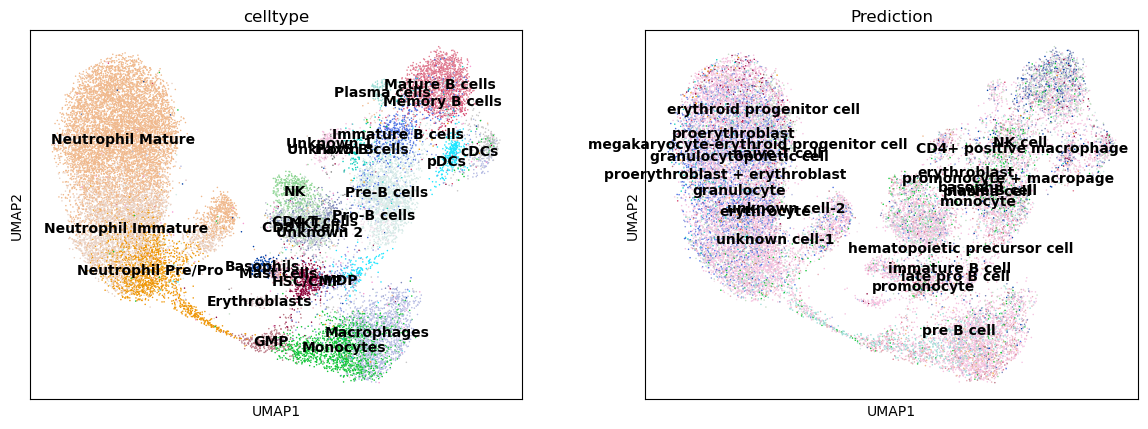

In [12]:
sc.pl.umap(new_adata, color=['celltype', 'Prediction'],legend_loc='on data')

#### Cluster level annotation

In [5]:
# Load data
adata = sc.read('results/mATLAS_droplet/annot.h5ad')
adata

AnnData object with n_obs × n_vars = 24807 × 299
    obs: 'Prediction', 'Probability', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'mitoPercent', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.2.5', 'seurat_clusters', 'old.ident', 'cluster_annot', 'celltype'

In [6]:
adata.obs['seurat_clusters'] = adata.obs['seurat_clusters'].astype('category')

# Aggregate to cluster level (e.g., based on Scanpy's Leiden clustering)
cluster_labels = (
    adata.obs.groupby("seurat_clusters")
    .agg(lambda x: x.value_counts().idxmax())  # Majority label per cluster
)

cluster_labels


#adata.obs['predicted_cluster_labels'] = adata.obs['old.ident'].map(cluster_labels['predicted_labels'])

,Prediction,Probability,nCount_RNA,nFeature_RNA,orig.ident,mitoPercent,nCount_SCT,nFeature_SCT,SCT_snn_res.2.5,old.ident,cluster_annot,celltype
seurat_clusters,,,,,,,,,,,,
0,erythroid progenitor cell,0.49982571601867676,773.0,510,AD Skull,0.0,1901.0,569,0,0,Neutrophil Mature,Neutrophil Mature
1,granulocytopoietic cell,0.999745786190033,1276.0,536,AD Skull,0.0,1926.0,446,1,1,Neutrophil Mature,Neutrophil Mature
2,promonocyte,0.9999488592147827,1188.0,644,WT Skull,1.4925373134328357,1961.0,681,2,2,Mature B cells,Mature B cells
3,granulocytopoietic cell,0.5973384380340576,2688.0,1019,WT Skull,0.0,2536.0,995,3,3,Neutrophil Immature,Neutrophil Immature
4,erythroid progenitor cell,0.935937225818634,2366.0,760,WT Skull,0.0,2328.0,760,4,4,Neutrophil Mature,Neutrophil Mature
5,erythroid progenitor cell,0.9926891922950745,904.0,746,WT Skull,1.6666666666666667,1844.0,746,5,5,Pre-B cells,Pre-B cells
6,promonocyte,0.9928638935089111,3970.0,1793,AD Skull,0.5964214711729622,2633.0,1721,6,6,Macrophages,Macrophages
7,granulocytopoietic cell,0.4500444829463959,1625.0,578,AD Skull,0.0,2024.0,543,7,7,Neutrophil Immature,Neutrophil Immature
8,granulocytopoietic cell,0.9834386706352234,750.0,329,AD Skull,0.0,1683.0,456,8,8,Neutrophil Mature,Neutrophil Mature


In [ ]:
# Check cluster level annotation


NameError: name 'new_adata' is not defined

Training on pre-weights of 'human_gobp' mask:

In [11]:
!cp ./hGOBP_demo/model-0.pth ./pre_weights.pth

In [12]:
TOSICA.train(ref_adata, gmt_path='human_gobp', label_name='Celltype',pre_weights='pre_weights.pth',epochs=1)

cuda:0
Mask loaded!
<All keys matched successfully>
Model builded!


[valid epoch 0] loss: 0.040, acc: 0.992: 100%|██████████| 5096/5096 [00:31<00:00, 162.61it/s]


Training finished!
